# 02_data_analysis.ipynb

## Notebook Purpose
This notebook is designed to perform exploratory data analysis (EDA) on the preprocessed cryptocurrency data. It will generate visualizations to help understand the data, identify trends, and detect any patterns.

## Instructions
1. **Import Necessary Libraries**:
   - Import `pandas` for data manipulation.
   - Import `matplotlib` and `seaborn` for data visualization.

2. **Load Preprocessed Data**:
   - Load the preprocessed CSV files created in the previous notebook.

3. **Plot Closing Prices**:
   - Generate a plot showing the closing prices over time to observe overall trends.

4. **Plot Technical Indicators**:
   - Generate plots for the calculated technical indicators (e.g., SMA, EMA) to visualize their behavior over time.

5. **Correlation Analysis**:
   - Calculate and visualize the correlation matrix to understand relationships between different features.

## Example Code

```python
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
data_path = 'data/historical_data/btc_usd_preprocessed.csv'  # Update this path based on the selected cryptocurrency
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Plot technical indicators
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['SMA_50'], label='SMA 50')
plt.title('Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Display correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [1]:
# Cell 1: Import necessary libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("Libraries imported successfully.")
except ImportError as e:
    print(f"Error importing libraries: {e}")


Libraries imported successfully.


In [2]:
# Cell 2: Function to load data for multiple cryptocurrencies
def load_crypto_data(cryptos):
    data_frames = {}
    for crypto in cryptos:
        try:
            df = pd.read_csv(f'../data/cleaned_data/{crypto}_cleaned.csv', parse_dates=['Date'])
            df.set_index('Date', inplace=True)
            data_frames[crypto] = df
            print(f"Loaded {crypto} data.")
        except FileNotFoundError as e:
            print(f"Error loading data for {crypto}: {e}")
    return data_frames

cryptos = ["BTC", "ETH", "SOL"]
crypto_data = load_crypto_data(cryptos)


Loaded BTC data.
Loaded ETH data.
Loaded SOL data.


In [3]:
# Cell 3: Check data quality and label bad data
def check_data_quality(df, crypto):
    print(f"\nChecking data quality for {crypto} data...")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values)
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print("Number of duplicates:", duplicates)
    
    return df

for crypto, df in crypto_data.items():
    crypto_data[crypto] = check_data_quality(df, crypto)



Checking data quality for BTC data...
Missing values:
 Open      133
High      133
Low       133
Close     132
Volume      1
dtype: int64
Number of duplicates: 0

Checking data quality for ETH data...
Missing values:
 Open      133
High      133
Low       133
Close     132
Volume      1
dtype: int64
Number of duplicates: 757

Checking data quality for SOL data...
Missing values:
 Open      133
High      133
Low       133
Close     132
Volume      1
dtype: int64
Number of duplicates: 2465


In [4]:
# Cell 4: Clean data by filling missing values and removing duplicates
def clean_data(df):
    # Fill missing values (forward fill for time series data)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df

cleaned_data = {crypto: clean_data(df) for crypto, df in crypto_data.items()}


In [5]:
# Cell 5: Save cleaned data
def save_cleaned_data(cleaned_data):
    for crypto, df in cleaned_data.items():
        df.to_csv(f'../data/cleaned_data/{crypto}_cleaned.csv')
        print(f"Cleaned data for {crypto} saved to ../data/cleaned_data/{crypto}_cleaned.csv")

save_cleaned_data(cleaned_data)


Cleaned data for BTC saved to ../data/cleaned_data/BTC_cleaned.csv
Cleaned data for ETH saved to ../data/cleaned_data/ETH_cleaned.csv
Cleaned data for SOL saved to ../data/cleaned_data/SOL_cleaned.csv


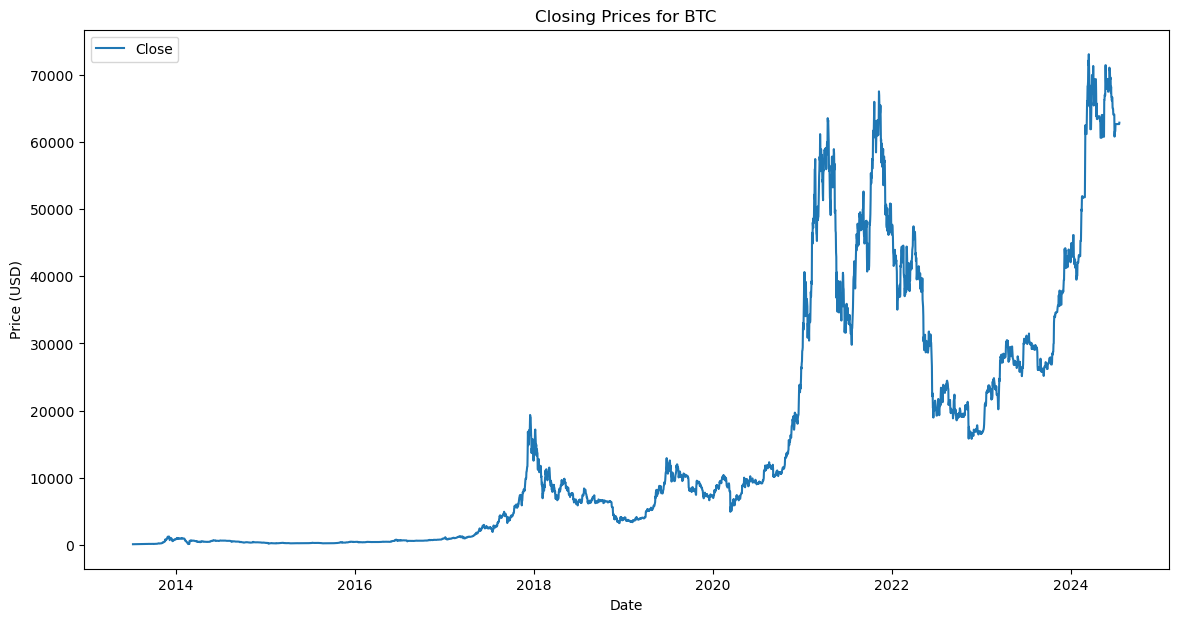

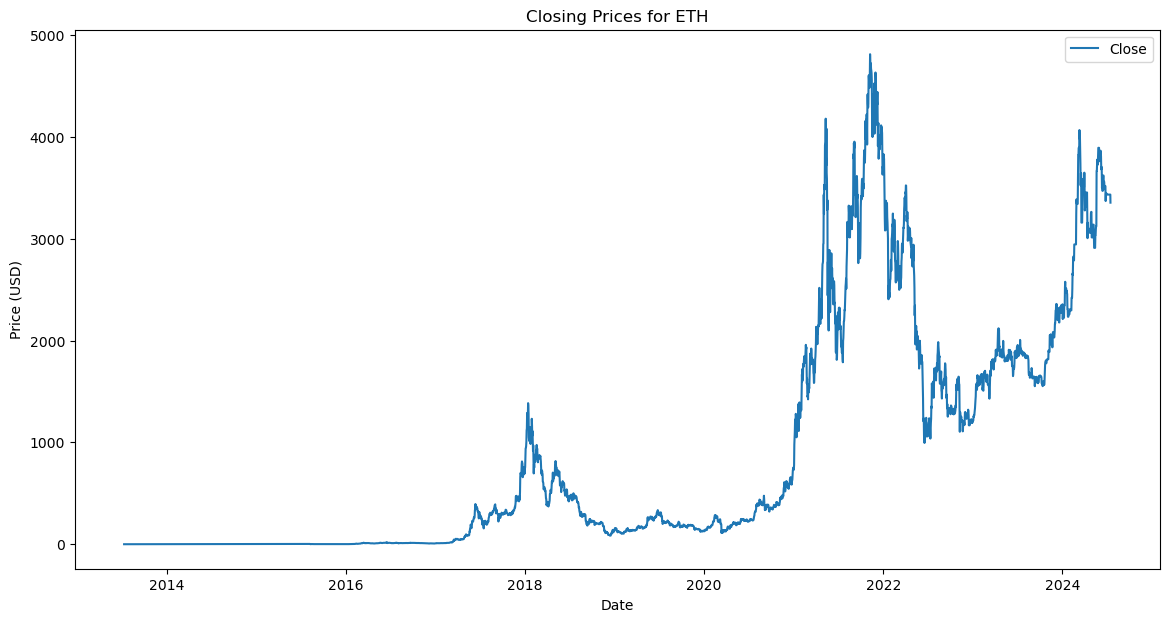

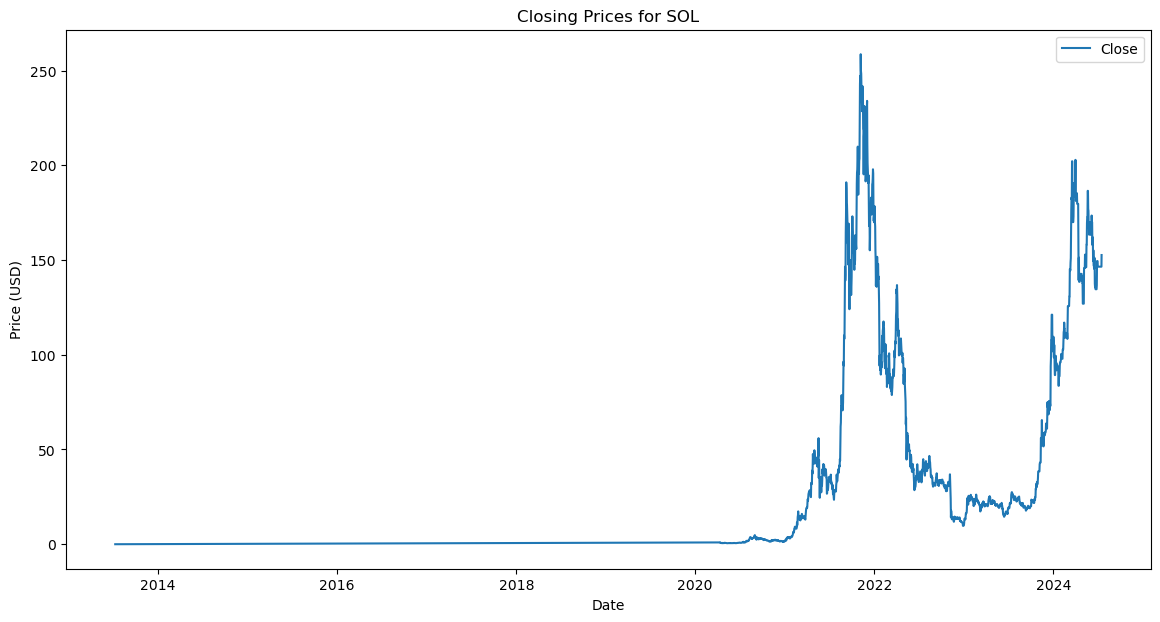

In [6]:
# Cell 6: Plot closing prices
def plot_closing_prices(df, crypto):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close')
    plt.title(f'Closing Prices for {crypto}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

for crypto, df in cleaned_data.items():
    plot_closing_prices(df, crypto)


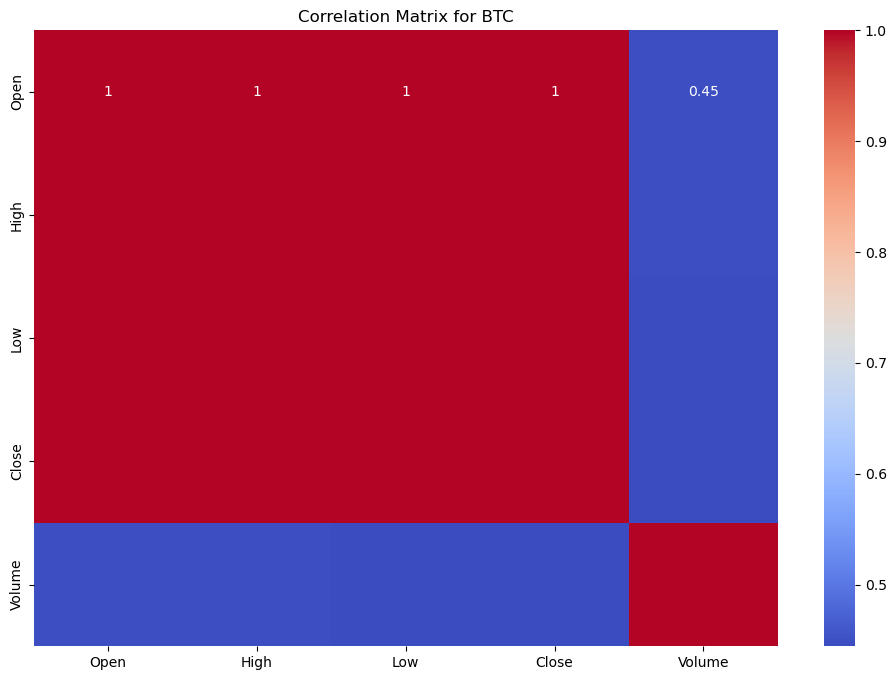

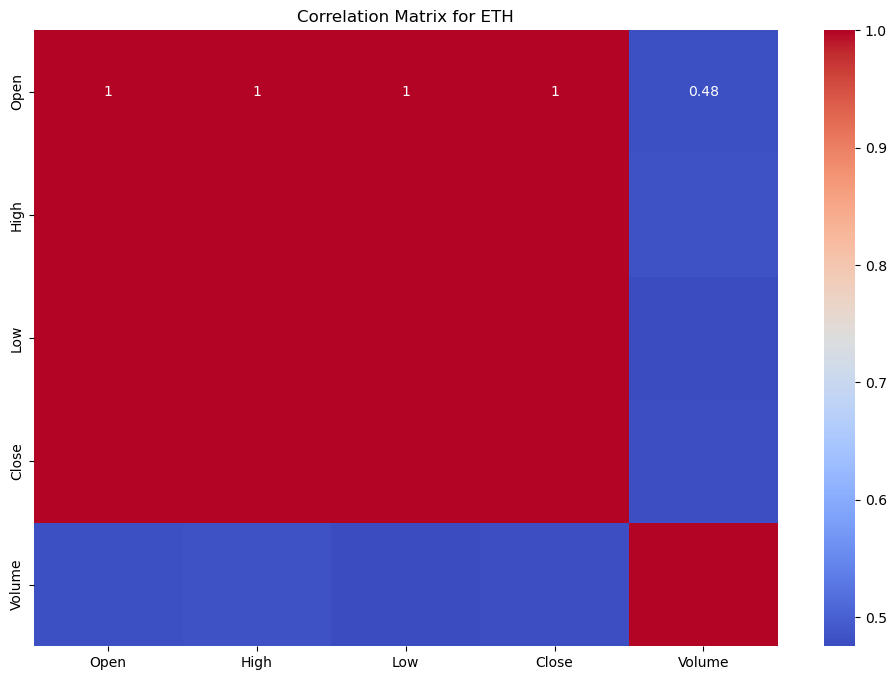

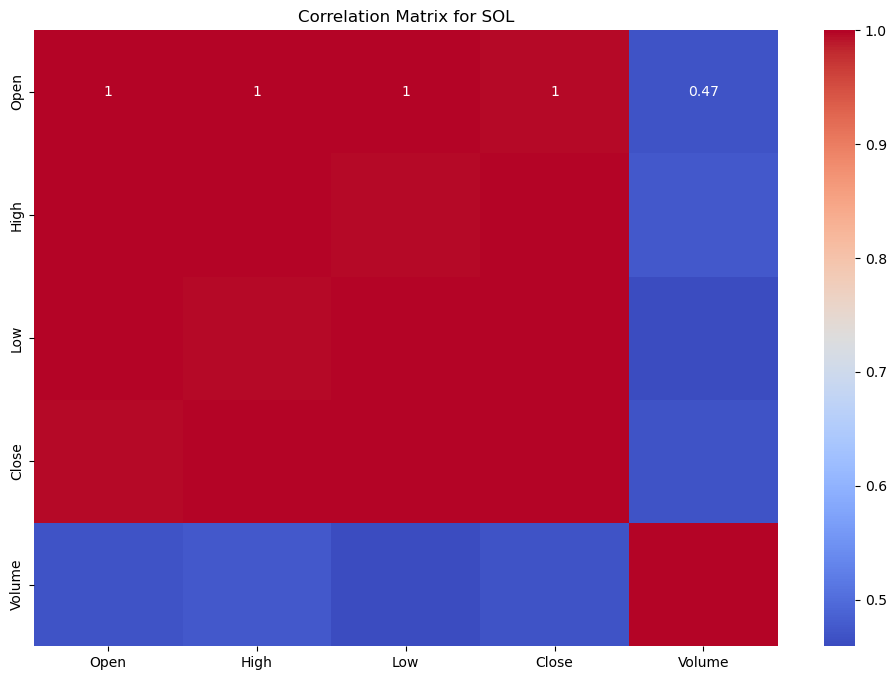

In [7]:
# Cell 7: Display correlation matrix
def plot_correlation_matrix(df, crypto):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {crypto}')
    plt.show()

for crypto, df in cleaned_data.items():
    plot_correlation_matrix(df, crypto)


In [8]:
# Cell 8: Save analysis with timestamp
import os
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
analysis_folder = f'../results/{timestamp}_analysis'
os.makedirs(analysis_folder, exist_ok=True)

def save_analysis(cleaned_data, folder):
    for crypto, df in cleaned_data.items():
        df.to_csv(f'{folder}/{crypto}_analysis.csv')
        print(f"Analysis data for {crypto} saved to {folder}/{crypto}_analysis.csv")

save_analysis(cleaned_data, analysis_folder)


Analysis data for BTC saved to ../results/20240715_092333_analysis/BTC_analysis.csv
Analysis data for ETH saved to ../results/20240715_092333_analysis/ETH_analysis.csv
Analysis data for SOL saved to ../results/20240715_092333_analysis/SOL_analysis.csv
